# Problem/need: Predicting whether police use of force will result in substantial physical injury, serious physical injury or death of a subject

recall = tp/ap = tp/(tp+fn)

Since false negatives (predicting that use of force doesn't result in a subject being substantially or seriously physically injured or dying when it actually does) are more costly, I'm going to weight recall more heavily than precision by using F2 as my evaluation metric.

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

import imblearn.over_sampling

In [3]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [4]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in NYPD Use of Force datasets

## incidents

In [5]:
incidents = pd.read_csv('NYPD_Use_of_Force_Incidents.csv')

In [6]:
incidents.shape

(13527, 7)

In [7]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527 entries, 0 to 13526
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  13527 non-null  int64 
 1   ForceType            13527 non-null  object
 2   Occurrence Date      13527 non-null  object
 3   Incident Pct         13527 non-null  int64 
 4   Patrol Borough       13527 non-null  object
 5   YearMonthShort       13527 non-null  object
 6   BasisForEncounter    13527 non-null  object
dtypes: int64(2), object(5)
memory usage: 739.9+ KB


## members of service

In [8]:
members = pd.read_csv('NYPD_Use_of_Force__Members_of_Service.csv')

In [9]:
members.shape

(31257, 8)

In [10]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31257 entries, 0 to 31256
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  31257 non-null  int64 
 1   ForceType            31257 non-null  object
 2   InjuryLevel          31257 non-null  object
 3   Member Injured       31257 non-null  object
 4   Rank Grouped         31257 non-null  object
 5   Assignment           31257 non-null  object
 6   Member Gender        31257 non-null  object
 7   Race                 31257 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.9+ MB


## subjects

In [11]:
subjects = pd.read_csv('NYPD_Use_of_Force__Subjects.csv')

In [12]:
subjects.shape

(13283, 8)

In [13]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13283 entries, 0 to 13282
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRI Incident Number   13283 non-null  int64  
 1   Subject Injury Level  13283 non-null  object 
 2   Subject Injured       13283 non-null  object 
 3   Age                   12741 non-null  float64
 4   Subject Race          13283 non-null  object 
 5   Subject Gender        13283 non-null  object 
 6   Force Against MOS     13283 non-null  object 
 7   Subject Used Force    13283 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 830.3+ KB


# Brielfy analyze individual datasets

## incidents

In [14]:
incidents.columns

Index(['TRI Incident Number', 'ForceType', 'Occurrence Date', 'Incident Pct',
       'Patrol Borough', 'YearMonthShort', 'BasisForEncounter'],
      dtype='object')

In [15]:
incidents['Occurrence Date'].value_counts()

06/01/2020    82
01/01/2020    69
06/02/2020    64
05/29/2020    63
05/31/2020    51
              ..
07/17/2020     4
07/18/2020     4
03/28/2021     4
07/16/2020     2
07/06/2020     1
Name: Occurrence Date, Length: 731, dtype: int64

In [16]:
incidents['ForceType'].value_counts()

Physical Force              10172
Electrical Weapon            2855
OC Spray                      259
Impact Weapon                 142
Firearm                        88
Restraining Mesh Blanket        8
Police Canine                   3
Name: ForceType, dtype: int64

In [17]:
incidents['BasisForEncounter'].value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
NON-CRIME CALLS FOR SERVICE                95
ORDER OF PROTECTION                        95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
AMBUSH OF MEMBER                           23
SEARCH WARRANT                             23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: BasisForEncounter, dtype: int64

## members

In [18]:
members.columns

Index(['TRI Incident Number', 'ForceType', 'InjuryLevel', 'Member Injured',
       'Rank Grouped', 'Assignment', 'Member Gender', 'Race'],
      dtype='object')

In [19]:
members['InjuryLevel'].value_counts()

No Injury                      25794
Physical Injury                 5062
Substantial Physical Injury      261
Serious Physical Injury          140
Name: InjuryLevel, dtype: int64

In [20]:
members['Rank Grouped'].value_counts()

Police Officer      26512
Sergeant             2353
Detective            1251
Lieutenant            718
Other                 290
Captain                71
Deputy Inspector       26
Inspector              15
Chief                  13
RECODE                  8
Name: Rank Grouped, dtype: int64

In [21]:
members['Assignment'].value_counts()

SECTOR/RESPONSE AUTO    19003
OTHER                    6168
FIXED POST               1919
ANTI-CRIME               1897
NCO                      1122
INVESTIGATION            1055
OFF DUTY                   71
SCOOTER                    22
Name: Assignment, dtype: int64

In [22]:
members['Member Gender'].value_counts()

MALE      27817
FEMALE     3440
Name: Member Gender, dtype: int64

In [23]:
members['Race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: Race, dtype: int64

## subjects

In [24]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

In [25]:
subjects['Subject Injury Level'].value_counts()

No Injury                      8988
Physical Injury                4009
Substantial Physical Injury     151
Serious Physical Injury         115
Death                            20
Name: Subject Injury Level, dtype: int64

In [26]:
subjects['Force Against MOS'].value_counts()

Physical Force        11552
No Force               1434
Displayed Weapon        158
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: Force Against MOS, dtype: int64

In [27]:
subjects['Subject Race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: Subject Race, dtype: int64

# Clean individual datasets

In [28]:
# clean up column names in datasets

incidents.columns = incidents.columns.str.lower().str.replace(' ','_')
members.columns = members.columns.str.lower().str.replace(' ','_')
subjects.columns = subjects.columns.str.lower().str.replace(' ','_')

In [29]:
incidents['occurrence_date_rev'] = pd.to_datetime(incidents['occurrence_date'])

In [30]:
incidents['occurrence_date_rev'].min()

Timestamp('2020-01-01 00:00:00')

In [31]:
incidents['occurrence_date_rev'].max()

Timestamp('2021-12-31 00:00:00')

In [32]:
incidents['year'] = incidents['occurrence_date_rev'].dt.year
incidents['month'] = incidents['occurrence_date_rev'].dt.month

# Merge subjects and incidents datasets

Each observation = subject of an incident

In [33]:
subjects_incidents = subjects.merge(incidents,how='left',on='tri_incident_number')

In [34]:
subjects_incidents.shape

(13283, 17)

In [35]:
subjects.shape

(13283, 8)

In [36]:
incidents.shape

(13527, 10)

In [37]:
subjects_incidents.columns

Index(['tri_incident_number', 'subject_injury_level', 'subject_injured', 'age',
       'subject_race', 'subject_gender', 'force_against_mos',
       'subject_used_force', 'forcetype', 'occurrence_date', 'incident_pct',
       'patrol_borough', 'yearmonthshort', 'basisforencounter',
       'occurrence_date_rev', 'year', 'month'],
      dtype='object')

In [38]:
subjects_incidents['tri_incident_number'].nunique()

12633

In [39]:
# create target variable

injury_levels = ['Substantial Physical Injury','Serious Physical Injury','Death']

subjects_incidents['subject_inj_death'] = subjects_incidents['subject_injury_level'].apply(lambda x: 1 if x in injury_levels else 0)

In [40]:
# create first feature variable -> force against member of service or not

subjects_incidents = pd.get_dummies(subjects_incidents, columns=['subject_used_force'], drop_first=True)

# EDA and Baselining

0    0.978469
1    0.021531
Name: subject_inj_death, dtype: float64


<AxesSubplot:>

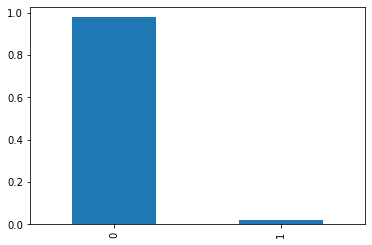

In [42]:
# check how imbalanced the target variable is

target_pcts = subjects_incidents.subject_inj_death.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar') # very imbalanced!

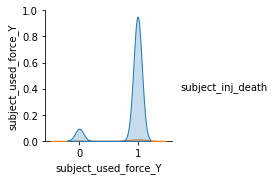

In [44]:
# create a helper function for plotting feature(s) vs target variable 

def plot_features(df, sample_size=500):
    
    sample = (df.sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='subject_inj_death', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(subjects_incidents[['subject_used_force_Y','subject_inj_death']])

In [58]:
subjects_incidents.columns

X_1 = np.array(subjects_incidents['subject_used_force_Y']).reshape(-1,1)
y = np.array(subjects_incidents['subject_inj_death'])

In [59]:
y.shape

(13283,)

In [60]:
X_1.shape

(13283, 1)

In [61]:
# split data into training/validation and test data

X_tr_val, X_te, y_tr_val, y_te = train_test_split(X_1, y, test_size=0.2, random_state=42)

In [79]:
# simple logistic regression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr_val, y_tr_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr, X_tr_val, y_tr_val, cv=kf, scoring='recall')

y_pred = lr.predict(X_tr_val)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

recall: [0. 0. 0. 0. 0.]

mean recall: 0.000

f2 score: 0.000


In [92]:
# logistic regression with over-sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr_val == 1)
n_neg = np.sum(y_tr_val == 0)
ratio = {1 : n_pos * 40, 0 : n_neg} 

# randomly oversample positive samples: create 10x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_val_rs, y_tr_val_rs = ROS.fit_resample(X_tr_val, y_tr_val)

lr_os = LogisticRegression(solver='lbfgs')
lr_os.fit(X_tr_val_rs, y_tr_val_rs)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_os, X_tr_val_rs, y_tr_val_rs, cv=kf, scoring='recall')

y_pred = lr_os.predict(X_tr_val)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

recall: [0.10798122 0.         0.         0.         0.        ]

mean recall: 0.022

f2 score: 0.000


In [ ]:
#incidents_members = incidents.merge(members,how='left',on='TRI Incident Number')

In [ ]:
#incidents_members.shape

In [ ]:
#df_merged = incidents.merge(members,how='left',on='TRI Incident Number').merge(subjects, how='left', on='TRI Incident Number')

In [ ]:
#df_merged.shape

In [ ]:
#df_merged.columns

In [ ]:
#df_merged['TRI Incident Number'].nunique()